# Date Preprocessing for EWMA Matlab

In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab

In [9]:
# data from 2017.1.1 to 2021.3.28
btc = pd.read_csv('data/BTC-USD.csv')
eth = pd.read_csv('data/ETH-USD.csv')
xrp = pd.read_csv('data/XRP-USD.csv')

In [10]:
# only using adj close data
btc_price = btc['Adj Close'].to_numpy()
eth_price = eth['Adj Close'].to_numpy()
xrp_price = xrp['Adj Close'].to_numpy()

In [11]:
date_array = btc['Date'].to_numpy()

In [12]:
price_dataset = pd.DataFrame({'Date': date_array, 'btc': btc_price, 'eth': eth_price, 'xrp': xrp_price})

In [13]:
price_dataset.isnull().values.any()

True

In [14]:
price_dataset = price_dataset.dropna()

In [15]:
# convert price to returns and adjust length
# e.g. 1.1 $100, 1.2 : $120, return: 1.2 with ln(120) - ln(100)
# u(i) = ln(s(i)/s(i-1))
return_btc = np.diff(np.log(price_dataset.btc), n=1, axis=0)
return_eth = np.diff(np.log(price_dataset.eth), n=1, axis=0)
return_xrp = np.diff(np.log(price_dataset.xrp), n=1, axis=0)

In [16]:
return_dataset = pd.DataFrame({'Date': price_dataset.Date.to_numpy()[1:], 'btc': return_btc, 'eth': return_eth, 'xrp': return_xrp})

In [17]:
return_dataset.isnull().values.any()

False

In [20]:
return_dataset.to_csv('returns.csv', index=False)  

In [21]:
# get the index from the df for 2018-01-01
i_2018 = return_dataset[return_dataset['Date']=='2018-01-01'].index[0]
print(i_2018)

363


In [22]:
return_data_2018 = return_dataset.iloc[i_2018:]

In [53]:
return_data_2018.to_csv('returns_2018.csv', index=False)  

In [24]:
return_data_2018.head()

,Date,btc,eth,xrp
363,2018-01-01,-0.035900,0.020804,0.038567
364,2018-01-02,0.092589,0.135145,0.036897
365,2018-01-03,0.014505,0.084803,0.224511
366,2018-01-04,0.025858,0.018730,0.028964
367,2018-01-05,0.110945,0.016980,-0.047379


# EWMA calculation

In [56]:
# data from 2017.1.1 to 2021.3.28
return_dataset = pd.read_csv('processed_data/returns.csv')
return_dataset_2018 = pd.read_csv('processed_data/returns_2018.csv')

In [32]:
y = return_dataset[['btc','eth','xrp']].to_numpy()
T = len(return_dataset)
VAR = np.full([T,3], np.nan)
COV = np.full([T,3], np.nan)
lmbda = 0.94
S = np.cov(y, rowvar = False)
S_matrix = np.full([T,3,3], np.nan)
S_matrix[0,] = S
VAR[0,] = [S[0,0],S[1,1],S[2,2]]
COV[0,] = [S[0,1],S[0,2],S[1,2]]

for i in range(1,T):
    S = lmbda * S_matrix[i-1] + (1-lmbda) * np.transpose(np.asmatrix(y[i-1]))* np.asmatrix(y[i-1])
    S_matrix[i] = S
    VAR[i,] = [S[0,0],S[1,1],S[2,2]] # var_btc,var_eth,var_xrp
    COV[i,] = [S[0,1],S[0,2],S[1,2]] # cov12,cov13,cov23

In [33]:
T_2018 =T - i_2018
VAR_2018 = np.full([T_2018,3], np.nan)
COV_2018 = np.full([T_2018,3], np.nan)

In [34]:
pVar = 0.05
Zscore = norm.ppf(pVar) 
# Get individual EWMA95
df_ewma_95 = pd.DataFrame({"btc":[],"var_95_btc":[],
                           "eth":[],"var_95_eth":[],
                           "xrp":[],"var_95_xrp":[]})

In [35]:
count = 0
for i in range(i_2018,T):
    VAR_2018[count,] = VAR[i,:]
    COV_2018[count,] = COV[i,:]
    v_var_95_btc, v_var_95_eth, v_var_95_xrp = -Zscore * np.sqrt(VAR[i,:])
    returns_btc_eth_xrp = return_dataset.iloc[i,:]
    v_return_btc = returns_btc_eth_xrp[1]
    v_return_eth = returns_btc_eth_xrp[2]
    v_return_xrp = returns_btc_eth_xrp[3]    
    update_data = [v_return_btc,v_var_95_btc, v_return_eth,v_var_95_eth, v_return_xrp,v_var_95_xrp]
    df_ewma_95.loc[count] = update_data
    count += 1

In [ ]:
df_ewma_95.to_excel("ewma_95.xlsx",index=False)

In [36]:
# save numpy array as npy file
from numpy import asarray
from numpy import save
data_var_2018 = asarray(VAR_2018)
# save to npy file
save('data_var.npy', data_var_2018)
data_cov = asarray(COV_2018)
# save to npy file
save('data_cov.npy', data_cov)

# Monte Carlo with EWMA

In [44]:
np.random.seed(42)
df_mc_95 = pd.DataFrame({"btc":[],"var_95_btc":[],
                           "eth":[],"var_95_eth":[],
                           "xrp":[],"var_95_xrp":[]})
for i in range (0,len(VAR_2018)):
    mean = 0
    std_all = np.sqrt(VAR_2018[i])
    std_btc = std_all[0]
    std_eth = std_all[1]
    std_xrp = std_all[2]
    n_sims = 1000
    sim_returns_btc = np.random.normal(mean, std_btc, n_sims)
    sim_returns_eth = np.random.normal(mean, std_eth, n_sims)
    sim_returns_xrp = np.random.normal(mean, std_xrp, n_sims)
    v_var_95_btc = -np.percentile(sim_returns_btc, 5)
    v_var_95_eth = -np.percentile(sim_returns_eth, 5)
    v_var_95_xrp = -np.percentile(sim_returns_xrp, 5)
    returns_btc_eth_xrp = return_data_2018.iloc[i,:]
    v_return_btc = returns_btc_eth_xrp[1]
    v_return_eth = returns_btc_eth_xrp[2]
    v_return_xrp = returns_btc_eth_xrp[3]    
    update_data = [v_return_btc,v_var_95_btc, v_return_eth,v_var_95_eth, v_return_xrp,v_var_95_xrp]
    df_mc_95.loc[i] = update_data

In [49]:
import matplotlib.pyplot as plt
# mu: mean
# sigma: real std
# s: simulated values
def plot_mc(mu,sigma,s):
    count, bins, ignored = plt.hist(s, 30, density=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
    plt.show()

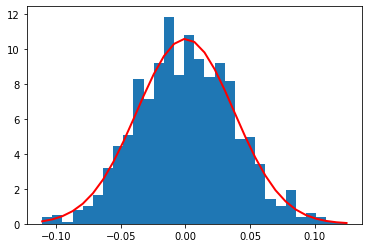

In [50]:
# plot last day btc
mu = 0
sigma = std_btc
s = sim_returns_btc
plot_mc(mu,sigma,s)

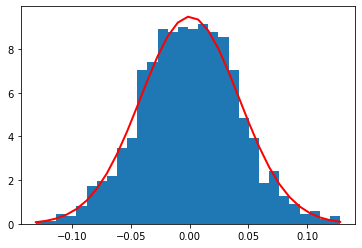

In [51]:
# plot last day eth
mu = 0
sigma = std_eth
s = sim_returns_eth
plot_mc(mu,sigma,s)

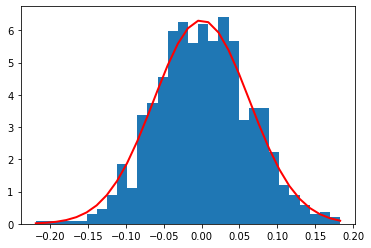

In [52]:
# plot last day xrp
mu = 0
sigma = std_xrp
s = sim_returns_xrp
plot_mc(mu,sigma,s)

In [46]:
df_mc_95.to_excel("df_mc_95.xlsx",index=False)

# Plot distributions

In [18]:
crptocurrencies = ['btc','eth','xrp']
weights = np.array([1/3,1/3,1/3]) # assume equal weightage
bins_num = 100

# var-cov matrix
cov_matrix = return_data_2018.cov()
# Calculate mean returns for each stock
avg_rets = return_data_2018.mean()
port_mean = avg_rets.dot(weights)
# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
# Repeat for each equity in portfolio
return_data_2018['btc'].hist(bins=bins_num, normed=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("BTC returns (binned) vs. normal distribution")
plt.show()

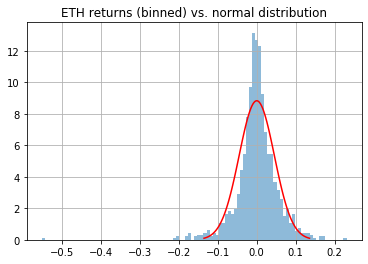

In [20]:
# Repeat for each equity in portfolio
return_data_2018['eth'].hist(bins=bins_num, normed=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("ETH returns (binned) vs. normal distribution")
plt.show()

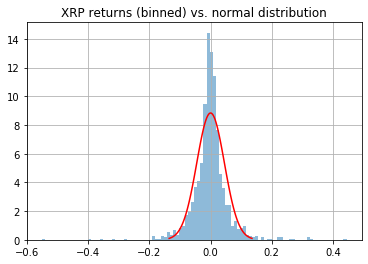

In [21]:
# Repeat for each equity in portfolio
return_data_2018['xrp'].hist(bins=bins_num, normed=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("XRP returns (binned) vs. normal distribution")
plt.show()

# User inputs for portforlio Var

In [ ]:
crptocurrencies = ['btc','eth','xrp']
# var-cov matrix
# cov_matrix = return_data_2018.cov()
# Calculate mean returns for each stock
# avg_rets = return_data_2018.mean()
# w_... : weight_...
# v_... : var...
# cov12 : covariance(1,2)
def portfolio_daily_var(w1,w2,w3,v1,v2,v3,cov12,cov13,cov23):
    return (w1**2)*v1 + (w2**2)*v2 + (w3**2)*v3 \
        + 2*w1*w2*cov12 + 2*w1*w3*cov13 + 2*w2*w3*cov23 

In [40]:
import math
btc_value = 3000
eth_value = 3200
xrp_value = 4800

def getVar(btc_value,eth_value,xrp_value):
    total_investment = btc_value + eth_value + xrp_value
    if (total_investment == 0): total_investment = 0.0000000000001
    w_btc = btc_value/total_investment
    w_eth = eth_value/total_investment
    w_xrp = xrp_value/total_investment
    weights = np.array([w_btc,w_eth,w_xrp]) # assume equal weightage
    portfolioVariance = np.zeros(T)
    for i in range(0,T):
        portfolioVariance[i] = portfolio_daily_var(w_btc,w_eth,w_xrp,
                                     VAR[i,0],VAR[i,1],VAR[i,2],
                                     COV[i,0],COV[i,1],COV[i,2])
    EWMA95 = np.zeros(T)
    EWMA95[0] = portfolioVariance[0]
    for t in range(1,len(return_data_2018)):
        Sigma = math.sqrt(portfolioVariance[t])
        EWMA95[t] = -Zscore*Sigma
    # new-day var in dollars
    var_1d1 = total_investment * EWMA95[-1]
    
    return var_1d1

In [41]:
getVar(btc_value,eth_value,xrp_value)

751.5856334214026

1 day VaR @ 95% confidence: 751.59
2 day VaR @ 95% confidence: 1062.9
3 day VaR @ 95% confidence: 1301.78
4 day VaR @ 95% confidence: 1503.17
5 day VaR @ 95% confidence: 1680.6
6 day VaR @ 95% confidence: 1841.0
7 day VaR @ 95% confidence: 1988.51
8 day VaR @ 95% confidence: 2125.81
9 day VaR @ 95% confidence: 2254.76
10 day VaR @ 95% confidence: 2376.72
11 day VaR @ 95% confidence: 2492.73
12 day VaR @ 95% confidence: 2603.57
13 day VaR @ 95% confidence: 2709.88
14 day VaR @ 95% confidence: 2812.18
15 day VaR @ 95% confidence: 2910.88


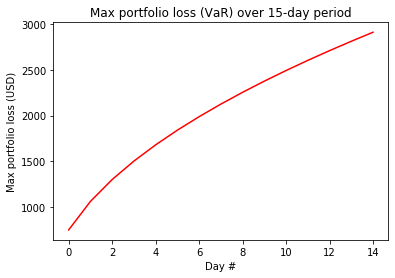

In [83]:

var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")
plt.show()

# Garch 1,1 Model

In [87]:
import numpy as np
import scipy
import pandas as pd
class garchOneOne(object):
       
    def __init__(self, logReturns):
        self.logReturns = logReturns * 100
        self.sigma_2 = self.garch_filter(self.garch_optimization())
        self.coefficients = self.garch_optimization()
        
    def garch_filter(self, parameters):
        "Returns the variance expression of a GARCH(1,1) process."
        
        # Slicing the parameters list
        omega = parameters[0]
        alpha = parameters[1]
        beta = parameters[2]
        
        # Length of logReturns
        length = len(self.logReturns)
        
        # Initializing an empty array
        sigma_2 = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_2[i] = omega / (1 - alpha - beta)
            else:
                sigma_2[i] = omega + alpha * self.logReturns[i-1]**2 + beta * sigma_2[i-1]
        
        return sigma_2 
        
    def garch_loglikehihood(self, parameters):
        "Defines the log likelihood sum to be optimized given the parameters."
        length = len(self.logReturns)
        
        sigma_2 = self.garch_filter(parameters)
        
        loglikelihood = - np.sum(-np.log(sigma_2) - self.logReturns**2 / sigma_2)
        return loglikelihood
    
    def garch_optimization(self):
        "Optimizes the log likelihood function and returns estimated coefficients"
        # Parameters initialization
        parameters = [.1, .05, .92]
        
        # Parameters optimization, scipy does not have a maximize function, so we minimize the opposite of the equation described earlier
        opt = scipy.optimize.minimize(self.garch_loglikehihood, parameters,
                                     bounds = ((.001,1),(.001,1),(.001,1)))
        
        variance = .01**2 * opt.x[0] / (1 - opt.x[1] - opt.x[2])   # Times .01**2 because it concerns squared returns
        
        return np.append(opt.x, variance)

In [88]:
def run_garch(data,cryptoType, conf_interval, dist_type):
    print("="*40)
    print("="*40)
    print ("Running Garch 1,1 model for %s" %cryptoType)
    model = garchOneOne(data)
    # upscale by 100 for better model performance, as garch model works better when y between 1 - 1000
    arch_m = arch_model(data * 100, mean = 'Zero', vol = 'GARCH', dist = dist_type, rescale=False)
    arch_m = arch_m.fit()
#     conf_int = pd.DataFrame(arch_m.conf_int(alpha = conf_interval))
#     conf_int['garchOneOne'] = model.coefficients[:-1]
#     conf_int['Test'] = np.where(conf_int['garchOneOne'] < conf_int['upper'], np.where(conf_int['garchOneOne'] > conf_int['lower'], "Ok", "Not ok"), "Not ok") 
#     print("conf_int for %s" %cryptoType)
#     print(conf_int)
    
#     %matplotlib inline
#     print(df.head())
#     # Plotting the data
#     plt.plot(df, label = ' GARCH(1,1)', linewidth = .75)
#     plt.legend()
#     plt.title('GARCH(1,1) processes of %s' %cryptoType, fontweight = 'bold')
#     return model.sigma_2
    return np.sqrt(model.sigma_2) / 100

In [ ]:
from scipy.stats import norm

In [89]:
btc_sigma = run_garch(return_dataset.btc.to_numpy(), "BTC", 0.05,'normal')
eth_sigma = run_garch(return_dataset.eth.to_numpy(), "ETH", 0.05,'normal')
xrp_sigma = run_garch(return_dataset.xrp.to_numpy(), "XRP", 0.05,'normal')

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4025613.013566537
Iteration:      2,   Func. Count:     11,   Neg. LLF: 4384.9916204200945
Iteration:      3,   Func. Count:     17,   Neg. LLF: 4377.081683321308
Iteration:      4,   Func. Count:     22,   Neg. LLF: 4342.7006551754475
Iteration:      5,   Func. Count:     27,   Neg. LLF: 4607.285736210748
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4334.61479813538
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4334.57578408737
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4334.573435790055
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4334.573379604806
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4334.573375595739
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4334.573375596127
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4334.573375595739
            Iterations: 11
            Function evaluations: 51
    

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log


In [94]:
var_btc = np.abs(-norm.ppf(0.05)*btc_sigma[363:]) 
var_eth = np.abs(-norm.ppf(0.05)*eth_sigma[363:])
var_xrp = np.abs(-norm.ppf(0.05)*xrp_sigma[363:])
gamma_vol_95 = pd.DataFrame({'btc': return_data_2018.btc, 'var_95_btc': var_btc,
              'eth': return_data_2018.eth, 'var_95_eth': var_eth,
              'xrp': return_data_2018.xrp, 'var_95_xrp': var_xrp})
gamma_vol_95.to_csv('gammas_normal.csv', index=False)  

In [140]:
btc_sigma = run_garch(return_data_2018.btc.to_numpy(), "BTC", 0.05,'studentst')
eth_sigma = run_garch(return_data_2018.eth.to_numpy(), "ETH", 0.05,'studentst')
xrp_sigma = run_garch(return_data_2018.xrp.to_numpy(), "XRP", 0.05,'studentst')
var_btc = np.abs(-norm.ppf(0.05)*btc_sigma)
var_eth = np.abs(-norm.ppf(0.05)*eth_sigma)
var_xrp = np.abs(-norm.ppf(0.05)*xrp_sigma)
gamma_vol_95 = pd.DataFrame({'btc': return_data_2018.btc, 'var_95_btc': var_btc,
              'eth': return_data_2018.eth, 'var_95_eth': var_eth,
              'xrp': return_data_2018.xrp, 'var_95_xrp': var_xrp})
gamma_vol_95.to_excel('gammas_studentt.xlsx', index=False)  

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      5,   Neg. LLF: -2320.6050656523958
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2320.605065866496
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Running Garch 1,1 model for ETH


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This wa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1977.2479809660442
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1977.2479810976913
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Running Garch 1,1 model for XRP
Iteration:      1,   Func. Count:      6,   Neg. LLF: 14202.38763689252
Iteration:      2,   Func. Count:     12,   Neg. LLF: -1578.0979833801707
Iteration:      3,   Func. Count:     20,   Neg. LLF: -921.1561372126803
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1071.7996623242047
Iteration:      5,   Func. Count:     32,   Neg. LLF: 673.3230982086244
Iteration:      6,   Func. Count:     41,   Neg. LLF: -1910.6770849384413
Iteration:      7,   Func. Count:     47,   Neg. LLF: -1304.9013812637888
Iteration:      8,   Func. Count:     53,   Neg. LLF: -2028.0516842832913
Iteration:      9,   Func. Count:     58,   Neg. LLF: -2029.7873672056598
Iteration:     10,   Func

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [141]:
btc_sigma = run_garch(return_data_2018.btc.to_numpy(), "BTC", 0.05,'skewt')
eth_sigma = run_garch(return_data_2018.eth.to_numpy(), "ETH", 0.05,'skewt')
xrp_sigma = run_garch(return_data_2018.xrp.to_numpy(), "XRP", 0.05,'skewt')
var_btc = np.abs(-norm.ppf(0.05)*btc_sigma)
var_eth = np.abs(-norm.ppf(0.05)*eth_sigma)
var_xrp = np.abs(-norm.ppf(0.05)*xrp_sigma)
gamma_vol_95 = pd.DataFrame({'btc': return_data_2018.btc, 'var_95_btc': var_btc,
              'eth': return_data_2018.eth, 'var_95_eth': var_eth,
              'xrp': return_data_2018.xrp, 'var_95_xrp': var_xrp})
gamma_vol_95.to_excel('gammas_skewt.xlsx', index=False)  

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      6,   Neg. LLF: -2320.6050651179103
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2320.605065866496
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1
Running Garch 1,1 model for ETH


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This wa

Iteration:      1,   Func. Count:      6,   Neg. LLF: -1977.2479806076685
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1977.2479810976913
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1
Running Garch 1,1 model for XRP
Iteration:      1,   Func. Count:      7,   Neg. LLF: 40367.61186267997
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5198.870475077545
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1346.3312481354465
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1733.4603608714128
Iteration:      5,   Func. Count:     40,   Neg. LLF: -1716.9568867619496
Iteration:      6,   Func. Count:     47,   Neg. LLF: -990.6410231829343
Iteration:      7,   Func. Count:     54,   Neg. LLF: -1396.6179127003707
Iteration:      8,   Func. Count:     61,   Neg. LLF: -1317.409726265208
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1928.3368871605696
Iteration:     10,   Func. 

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [142]:
btc_sigma = run_garch(return_data_2018.btc.to_numpy(), "BTC", 0.05,'ged')
eth_sigma = run_garch(return_data_2018.eth.to_numpy(), "ETH", 0.05,'ged')
xrp_sigma = run_garch(return_data_2018.xrp.to_numpy(), "XRP", 0.05,'ged')
var_btc = np.abs(return_data_2018.btc.to_numpy()-norm.ppf(0.05)*btc_sigma)
var_eth = np.abs(return_data_2018.eth.to_numpy()-norm.ppf(0.05)*eth_sigma)
var_xrp = np.abs(return_data_2018.xrp.to_numpy()-norm.ppf(0.05)*xrp_sigma)
gamma_vol_95 = pd.DataFrame({'btc': return_data_2018.btc, 'var_95_btc': var_btc,
              'eth': return_data_2018.eth, 'var_95_eth': var_eth,
              'xrp': return_data_2018.xrp, 'var_95_xrp': var_xrp})
gamma_vol_95.to_excel('gammas_ged.xlsx', index=False)  

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      5,   Neg. LLF: -2267.711835497006
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2267.7118381040423
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Running Garch 1,1 model for ETH


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This wa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1941.0786464264697
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1941.078648393754
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Running Garch 1,1 model for XRP
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1250388.3993422482
Iteration:      2,   Func. Count:     12,   Neg. LLF: -1514.4443820773272
Iteration:      3,   Func. Count:     18,   Neg. LLF: -1726.2637400919775
Iteration:      4,   Func. Count:     24,   Neg. LLF: 2055.808650241822
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1928.031192561968
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1993.5466140111596
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1850.933292015438
Iteration:      8,   Func. Count:     51,   Neg. LLF: -1995.0361170716074
Iteration:      9,   Func. Count:     58,   Neg. LLF: -1994.1543445637851
Iteration:     10,   Func.

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


# Monte Carlo

In [99]:
ewma_data = pd.read_csv('ewma.csv', header=None)
monte_carlo_data = pd.read_csv('monte_carlo.csv', header=None)

In [100]:
ewma_data.head()

,0,1,2,3,4,5
0,0.092589,0.21671,0.135140,0.24658,0.036897,0.32253
1,0.014505,0.14050,0.084803,0.20579,0.224510,0.50184
2,0.025858,0.14815,0.018730,0.14091,0.028964,0.31266
3,0.110940,0.22997,0.016980,0.13568,-0.047379,0.22792
4,0.005578,0.12933,0.043117,0.15840,0.014737,0.28233


In [101]:
len(return_data_2018.Date.to_numpy())

1176

In [102]:
len(ewma_data[1])

1176

In [105]:
gammas_data.head()

,btc,var_95_btc,eth,var_95_eth,xrp,var_95_xrp
0,0.092589,0.095197,0.135145,0.139901,0.036897,0.101614
1,0.014505,0.017440,0.084803,0.092767,0.224511,0.245682
2,0.025858,0.028513,0.018730,0.026075,0.028964,0.094273
3,0.110945,0.113525,0.016980,0.022571,-0.047379,0.026643
4,0.005578,0.008679,0.043117,0.047771,0.014737,0.024711


In [106]:
len(gammas_data['var_95_btc'])

1176

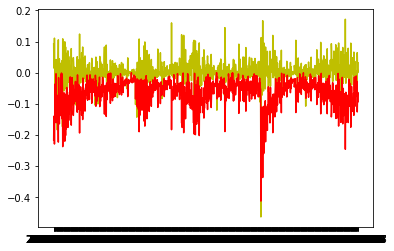

In [113]:
import matplotlib.pyplot as plt
plt.plot(return_data_2018.Date.to_numpy(),ewma_data[0],'y')
plt.plot(return_data_2018.Date.to_numpy(),-ewma_data[1],'r')
plt.show()

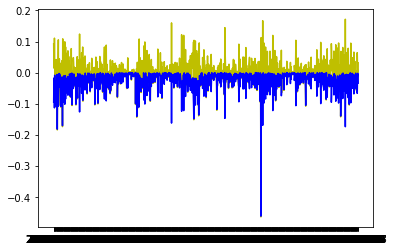

In [114]:
plt.plot(return_data_2018.Date.to_numpy(),ewma_data[0],'y')
plt.plot(return_data_2018.Date.to_numpy(),-gammas_data['var_95_btc'],'b')
plt.show()

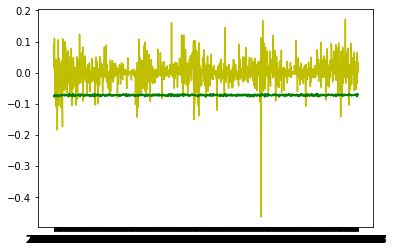

In [115]:
plt.plot(return_data_2018.Date.to_numpy(),ewma_data[0],'y')
plt.plot(return_data_2018.Date.to_numpy(),-monte_carlo_data[1],'g')
plt.show()